In [191]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from sklearn.model_selection import train_test_split


In [192]:
# reading the dataset

movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python')
users = pd.read_csv('ml-1m/users.dat', sep='::', header=None, engine='python')
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')

In [193]:
#movies.head()
users.head()
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [194]:
# training_set = pd.read_csv('ml-100k/u1.base', delimiter='\t')
# #training_set = np.array(training_set, dtype='int')

# testing_set = pd.read_csv('ml-100k/u1.test', delimiter='\t')
# #testing_set = np.array(testing_set, dtype='int64')
# training_set.head()

training_set, testing_set = train_test_split(ratings, train_size=0.75)

In [195]:
print(training_set.shape)
print(testing_set.shape)

(750156, 4)
(250053, 4)


In [196]:
# row:-  userId :: movieId :: rating(0-5) :: timestamp

training_set.head()

,0,1,2,3
371859,2172,2003,3,1015105588
141469,911,434,1,975206460
315300,1880,2312,4,975379429
653196,3937,1210,5,965700048
58030,392,3424,4,976304378


In [197]:
# get the maximum id of both user and movies from the combined training and testing data set
max_user_id = max (max(training_set.iloc[:,0]), max(testing_set.iloc[:, 0]))
max_movies_id = max (max(training_set.iloc[:, 1]), max(testing_set.iloc[:, 1]))

In [198]:
print(max_user_id)
print(max_movies_id)
type(max_user_id)

6040
3952


int

In [199]:
def transform(data):
    new_data = []
    for i in range(1, max_user_id+1):
        movies_id = data.iloc[:, 1][data.iloc[:,0] == i]
        rating_id = data.iloc[:, 2][data.iloc[:,0] == i]
        ratings = np.zeros(max_movies_id)
        ratings[movies_id-1] = rating_id
        new_data.append(list(ratings))
        
    return new_data
        

In [200]:
# convert the traning data and testing data
training_set = transform(training_set)
testing_set = transform(testing_set)

In [201]:
print(len(training_set))
print(len(training_set[0]))

6040
3952


In [202]:
print(len(testing_set))
print(len(testing_set[0]))

6040
3952


In [203]:
# convert the training set and testing set to tensor
training_set = torch.FloatTensor(training_set)
testing_set = torch.FloatTensor(testing_set)

In [204]:
# converting the ratings to binary as RBM works on binary set only
training_set[training_set == 0] = -1 # no rating
training_set[training_set == 1] = 0  # bad movie
training_set[training_set == 2] = 0 # bad movie
training_set[training_set > 2] = 1 # good movie


testing_set[testing_set == 0] = -1 # no rating
testing_set[testing_set == 1] = 0  # bad movie
testing_set[testing_set == 2] = 0 # bad movie
testing_set[testing_set > 2] = 1  # good movie 

In [205]:
'''
GenerativeModels H. G.M.
Github repository
'''
class RBM:
    def __init__(self, num_visible, num_hidden):
        #self.num_visible = num_visible
        #self.num_hidden = num_hidden
        
        # initialize the weights with random
        self.W = torch.randn(num_hidden, num_visible)
        self.a = torch.randn(1, num_hidden)
        self.b = torch.randn(1, num_visible)
        print(self.W)
        
        
    def sample_hidden(self, x):
        Wx = torch.mm(x, self.W.t())  
        activation = Wx + self.a.expand_as(Wx)
        ph_given_v = torch.sigmoid(activation)
        return ph_given_v, torch.bernoulli(ph_given_v)
    
    
    def sample_visible(self, y):
        Wy = torch.mm(y, self.W)
        activation = Wy + self.b.expand_as(Wy)
        pv_given_h = torch.sigmoid(activation)
        return pv_given_h, torch.bernoulli(pv_given_h)
    
    def train (self, v0, vk, ph0, phk):
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0-phk), 0)
        
nv = len(training_set[0])
nh= 100
batch_size = 100
rbm = RBM(nv, nh)

tensor([[ 0.2756,  2.4720,  1.4491,  ...,  0.9280, -1.4229,  0.8039],
        [ 2.0500, -1.7728, -0.5405,  ..., -0.0167, -0.8337, -0.6020],
        [ 1.5795, -0.8202,  0.9582,  ..., -0.2405, -0.9903, -1.2395],
        ...,
        [-0.7488,  1.3128,  0.3053,  ...,  0.1726, -0.0504,  0.7839],
        [ 0.0331,  0.3238,  0.0288,  ..., -0.0796,  0.5397,  0.8873],
        [ 0.4304,  1.3914,  0.5983,  ..., -0.8464,  0.3124,  0.6137]])


In [206]:
nb_epoch = 20
rmse_erros = []
for epoch in range(1, nb_epoch+1):
    ##loss function
    train_loss = 0
    #normalize the loss, define a counter
    s = 0.
    #implement a batch learning, 
    for id_user in range(0, max_user_id - batch_size, 100):
        #input batch values
        vk = training_set[id_user: id_user+batch_size]
        #target used for loss mesarue: rating 
        v0 = training_set[id_user: id_user+batch_size]
        ##initilize probablity
        #pho: given real rating at begining, probablity of hidden nodes
        ph0, _ = rbm.sample_hidden(v0)
        #k step of constrative divergence
        for k in range(10):
            _, hk = rbm.sample_hidden(vk)
            _, vk = rbm.sample_visible(hk)
            #training on rating that do exist, rating as -1
            vk[v0<0] = v0[v0<0]
        phk, _ = rbm.sample_hidden(vk)
        #update weights and bias
        rbm.train(v0, vk, ph0, phk)
        #update train loss
        train_loss += torch.mean(torch.abs(v0[v0>=0]-vk[v0>=0])**2)
        s += 1
    print('epoch: '+str(epoch)+'RMSE loss: '+str(train_loss/s))
    rmse_erros.append(train_loss/s)
#     print(s)

epoch: 1RMSE loss: tensor(0.2444)
epoch: 2RMSE loss: tensor(0.2278)
epoch: 3RMSE loss: tensor(0.2274)
epoch: 4RMSE loss: tensor(0.2284)
epoch: 5RMSE loss: tensor(0.2281)
epoch: 6RMSE loss: tensor(0.2281)
epoch: 7RMSE loss: tensor(0.2289)
epoch: 8RMSE loss: tensor(0.2280)
epoch: 9RMSE loss: tensor(0.2281)
epoch: 10RMSE loss: tensor(0.2274)
epoch: 11RMSE loss: tensor(0.2279)
epoch: 12RMSE loss: tensor(0.2276)
epoch: 13RMSE loss: tensor(0.2275)
epoch: 14RMSE loss: tensor(0.2281)
epoch: 15RMSE loss: tensor(0.2280)
epoch: 16RMSE loss: tensor(0.2284)
epoch: 17RMSE loss: tensor(0.2277)
epoch: 18RMSE loss: tensor(0.2277)
epoch: 19RMSE loss: tensor(0.2281)
epoch: 20RMSE loss: tensor(0.2281)


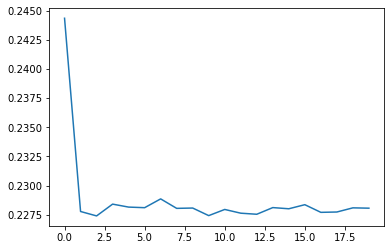

In [207]:
import matplotlib.pyplot as plt
plt.xlabel = 'epochs'
plt.ylabel = 'RMSE error'
plt.plot(list(range(20)), rmse_erros, "-")

In [208]:
##loss function
test_loss = 0
movies_like = torch.FloatTensor()
print(movies_like.shape)
s = 0.
#implement a batch learning, 
for id_user in range(0, max_user_id):
    v_input = training_set[id_user: id_user+1]
    v_target = testing_set[id_user: id_user+1]
    if len(v_target[v_target>=0]):
        _, h = rbm.sample_hidden(v_input)
        _, v_input = rbm.sample_visible(h)
        test_loss += torch.mean(torch.abs(v_target[v_target>=0]-v_input[v_target>=0])**2)    
        s += 1
        


torch.Size([0])


In [209]:
print(s)
print('test loss: ' +str(test_loss/s))

6038.0
test loss: tensor(0.2063)


In [210]:
id_user = 4500 #user id

v_input = training_set[id_user: id_user+1]

v_target = testing_set[id_user: id_user+1]
if len(v_target[v_target>=0]):
    _, h = rbm.sample_hidden(v_input)
    _, v_input = rbm.sample_visible(h)
    test_loss += torch.mean(torch.abs(v_target[v_target>=0]-v_input[v_target>=0])**2)    
    s += 1
v_lst = v_input.detach().numpy() 
v_lst = list(v_lst)

In [211]:
prediction = [] # prediction[i] == 1 if that movie is recommended otherwise 0
for v  in v_lst:
    l = list(v)
    prediction.append(l)
    
print(len(prediction[0]))

3952


In [215]:
ind = 0
output = [] # contains the movies name which are recommended by the model
for p in prediction[0]:
    if p == 1.0:
        output.append(movies.iloc[:,1][movies.iloc[:,0] == ind])
    ind += 1
print(len(output))   

2724


In [216]:
# randomly recommend the five movies from the recommended list
from random import seed
from random import randint
seed(1)

random_lst = []
for _ in range(5):
    random_lst.append(randint(0, len(output)-1))
    
for ind in random_lst:
    print (output[ind])

777    Gate of Heavenly Peace, The (1995)
Name: 1, dtype: object
3319    Harry and the Hendersons (1987)
Name: 1, dtype: object
341    Adventures of Priscilla, Queen of the Desert, ...
Name: 1, dtype: object
1467    Anaconda (1997)
Name: 1, dtype: object
661    Bloodsport 2 (1995)
Name: 1, dtype: object


In [217]:
# calculate the cosine similarity of the user
user_id = 4500
user = training_set[id_user: id_user+1]
user = user.detach().numpy()
print(user.shape)
print(type(training_set))
tr_set = training_set.detach().numpy()

similarity = []  

similarity = tr_set.dot(user.transpose())

(1, 3952)
<class 'torch.Tensor'>


In [218]:
print(similarity.shape)
sim = []
for lst in similarity:
    val = lst[0]
    sim.append(val)
    
similarity = sim # similarity list contains the cosine similarity for userid = 4500
print(len(similarity))


(6040, 1)
6040


In [101]:
#print(similarity)

In [223]:
similar_users = []  # contains the neighbors of user=4500
# get the top 5 user id with highest cosine value
# we can tune the number of neighbors we want to choose
# we can alos tune the score such that above this score are all neighbors of the particular user
sort_lst = np.argsort(similarity)
similar_users.append(sort_lst[-1])
similar_users.append(sort_lst[-2])
similar_users.append(sort_lst[-3])
similar_users.append(sort_lst[-4])
similar_users.append(sort_lst[-5])

In [222]:
print(similar_users)

[4500, 1770, 5983, 2874, 891]


In [224]:
neigh1 = training_set[similar_users[0]: similar_users[0]+1]
neigh1 = neigh1.detach().numpy()

neigh2 = training_set[similar_users[1]: similar_users[1]+1]
neigh2 = neigh2.detach().numpy()

neigh3 = training_set[similar_users[2]: similar_users[2]+1]
neigh3 = neigh3.detach().numpy()

neigh4 = training_set[similar_users[3]: similar_users[3]+1]
neigh4 = neigh4.detach().numpy()

neigh5 = training_set[similar_users[4]: similar_users[4]+1]
neigh5 = neigh5.detach().numpy()

In [225]:
neigh1 = neigh1.astype(int)
neigh2 = neigh2.astype(int)
neigh3 = neigh3.astype(int)
neigh4 = neigh4.astype(int)
neigh5 = neigh5.astype(int)
print(neigh1)

[[-1 -1 -1 ... -1 -1 -1]]


In [226]:
neigh_prediction1 = np.logical_or(neigh1==1, neigh2==1)
neigh_prediction2 = np.logical_or(neigh3==1,  neigh4==1)
neigh_prediction = np.logical_or(neigh_prediction1==1, neigh_prediction2==1)
neigh_prediction = np.logical_or(neigh_prediction==1, neigh5==1)
print(np.count_nonzero(neigh_prediction==1, axis=1))

[81]


In [227]:
print(neigh_prediction)
#neigh_prediction = neigh_prediction.astype(int)

print(np.count_nonzero(neigh_prediction==1, axis=1))
print(neigh_prediction.shape)
neigh_prediction = list(neigh_prediction)
sim_prediction = []
for n in neigh_prediction[0]:
    sim_prediction.append(n)
    
sim_prediction = list(sim_prediction)

[[False False False ... False False False]]
[81]
(1, 3952)


In [228]:
ind = 0
sim_output = []
print(type(sim_prediction[0]))
pred = prediction[0]
for ind in range(0,len(sim_prediction)):
    if sim_prediction[ind] == True:
        if pred[ind] == 1.:
            sim_output.append(ind)
    ind += 1
        

<class 'numpy.bool_'>


In [229]:
print(len(sim_output))

77
